## <center> Backtesting Framework </center>

**Summary** 

This code is dedicated to implementing a framework for backtesting the following strategy: every Y days go long (buy) the P% stocks with the lowest/higher X ratio. The example below uses X as being P/E ratio for every stock, but the code can be tested using any other metric on a per stock level, such as past 12-month return, past 12-month volatility, price-to-book ratio, EBITDA margins, return-on-equity etc. The short side of the strategy and an Index constraint for the stock selection universe should be implemented soon.

#### Importing the necessary modules:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import backtesting_tools as bt

#### Importing the data:

In [39]:
# Importing the closing prices data:
df_close = pd.read_csv("Data/Close - All Assets - Economatica.csv",sep=";",low_memory=False,index_col=0,
                       parse_dates=True, infer_datetime_format=True, skiprows=3)

# Importing the P/E data:
df_pe = pd.read_csv("Data/PE - All Assets - Economatica.csv",sep=";",low_memory=False,index_col=0,
                       parse_dates=True, infer_datetime_format=True, skiprows=3)

# Importing the marketcap data:
df_mktcap = pd.read_csv("Data/Market Cap - All Assets - Economatica.csv",sep=";",low_memory=False,index_col=0,
                       parse_dates=True, infer_datetime_format=True, skiprows=3)

# Importing the volume data:
df_volume = pd.read_csv("Data/Volume - All Assets - Economatica.csv",sep=";",low_memory=False,index_col=0,
                       parse_dates=True, infer_datetime_format=True, skiprows=3)

# Importing the IBOVESPA Index composition data:
df_index = pd.read_csv("Data/Comp IBOV - All Assets - Economatica.csv",sep=";",low_memory=False,index_col=0,
                       parse_dates=True, infer_datetime_format=True, skiprows=3)


# Renaming columns names from Economatica, so we can have only the tickers as column names:
df_close = df_close.rename(columns=lambda x: x.replace("Fechamento\najust p/ prov\nEm moeda orig\n",""))
df_pe = df_pe.rename(columns=lambda x: x.replace("P/L\nEm moeda orig\nde 12 meses\nconsolid:sim*\n",""))
df_mktcap = df_mktcap.rename(columns=lambda x: x.replace("Valor Mercado\nda empresa\nEm moeda orig\nem milhares\n",""))
df_volume = df_volume.rename(columns=lambda x: x.replace("Media\nnulos = 0\ndo volume$\nem 1 mês\nEm moeda orig\nem milhares\n",""))
df_index = df_index.rename(columns=lambda x: x.replace("Comp carteira\nem %\nIbovespa \n",""))

In [3]:
# Replacing values "-" with NaN ("-" happens in Economatica when there is no data for that date):
df_close = df_close.replace("-",np.nan)
df_pe = df_pe.replace("-",np.nan)
df_mktcap = df_mktcap.replace("-",np.nan)
df_volume = df_volume.replace("-",np.nan)
df_index = df_index.replace("-",np.nan)

In [4]:
# Replacing "," values with "":
df_mktcap = df_mktcap.apply(lambda x: x.str.replace(",",""),axis=1)
df_pe = df_pe.apply(lambda x: x.str.replace(",",""),axis=1)
df_close = df_close.apply(lambda x: x.str.replace(",",""),axis=1)
df_volume = df_volume.apply(lambda x: x.str.replace(",",""),axis=1)

In [5]:
# Turning data into numeric:
df_close = df_close.apply(pd.to_numeric, errors='coerce')
df_pe = df_pe.apply(pd.to_numeric, errors='coerce')
df_mktcap = df_mktcap.apply(pd.to_numeric, errors='coerce')
df_volume = df_volume.apply(pd.to_numeric, errors='coerce')

In [6]:
# Replacing negative P/E values with np.NaN
df_pe = df_pe.mask(df_pe<=0,np.nan)

#### Treating the data:

In [7]:
# Filling NaN's that happens to be between two existing dates (in this case we are filling with the last price data available):
df_close = df_close.apply(bt.fill_between,axis=0)
df_pe = df_pe.apply(bt.fill_between,axis=0)
df_mktcap = df_mktcap.apply(bt.fill_between,axis=0)
df_volume = df_volume.apply(bt.fill_between,axis=0)

In [8]:
# Setting the starting year:
year = "2000"
df_close = df_close.loc[year:]
df_pe = df_pe.loc[year:]

In [9]:
# Setting the signal dataframe:
df_signal = df_pe.copy()

#### Portfolio:

In [10]:
def strategy(df_close,  df_signal, df_mktcap, reb_days = 30, percentile = 0.2, mkt_cap = 1000000, low = True, volume = 10000):

    daily_ret = df_close.pct_change(1) # Defining a dataframe with daily returns

    data_signal_reb_days = df_signal.iloc[::reb_days] # Defining a dataframe with the signal data only at the rebalancing dates
    
    # Building a dictionary made of rebalancing dates as keys and a list of positions in each rebalancing dates:

    positions = {}

    for i in data_signal_reb_days.index: # Iterating over all rebalancing dates
        n = int(len(df_signal.loc[i][(df_mktcap.loc[i]>mkt_cap) & (df_volume.loc[i]>volume)].dropna())*percentile) # Defining the number of stocks to  buy
        if low:
            positions[i] = data_signal_reb_days.loc[i][(df_mktcap.loc[i]>mkt_cap) & (df_volume.loc[i]>volume)].dropna().sort_values().head(n).index.to_list() # n stocks with lower ratios and mkt cap above threshold
        else:
            positions[i] = data_signal_reb_days.loc[i][(df_mktcap.loc[i]>mkt_cap) & (df_volume.loc[i]>volume)].dropna().sort_values().tail(n).index.to_list() # n stocks with higher ratios and mkt cap above threshold
    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # Building a dataframe with the percentage weights for each stock in every day:

    reb_days_weights = data_signal_reb_days.copy() # Defining a dataframe to store the percentage weights for each stock
    reb_days_weights[:] = 0 # Setting all values to zero
    
    for i in reb_days_weights.index: # Iterating over every rebalancing date
        reb_days_weights.loc[i][positions[i]] = 1 # Inserting values 1 for each stock present in the portfolio
        
    reb_days_weights = reb_days_weights.div(reb_days_weights.sum(axis=1),axis=0) # Turning the 1's into percentage equal weights

    daily_weights = daily_ret.copy() # Defining a dataframe to store percentage weights for every day
    daily_weights[:] = 0
    daily_weights.loc[reb_days_weights.index] = reb_days_weights # Inserting the weights in every rebalancing date
    previous_day = daily_weights.index[0] 
    
    for i in daily_weights.index[1:]: # Iterating over every day to get the weights for days outside of rebalancing dates
        if all(daily_weights.loc[i]==0):
            daily_weights.loc[i] = daily_weights.loc[previous_day]*(daily_ret.loc[i].add(1)) # Growing weights with returns
        previous_day = i
        
    daily_weights = daily_weights.div(daily_weights.sum(axis=1),axis=0) # Setting percentage weights for each day

    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # Getting the strategy returns and performance:

    strategy_rets = (daily_weights.shift(1)*daily_ret).sum(axis=1) # Getting daily returns
    strategy_perf = strategy_rets.add(1).cumprod() # Getting daily wealth

    return {"returns": strategy_rets, "positions": positions, "daily weights": daily_weights} # returning a dict with the results


#### Portfolio Results:

In [33]:
results = strategy(df_close, df_signal, df_mktcap, reb_days = 30, percentile = 0.2, mkt_cap = 0, volume = 5000, low = True)

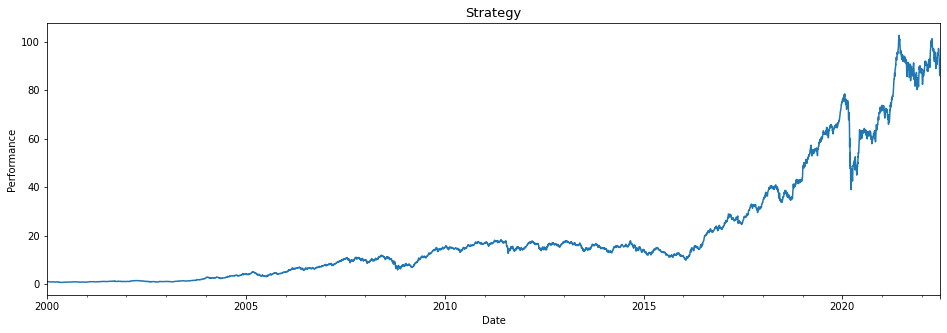

In [34]:
results["returns"].add(1).cumprod().plot(figsize=(16,5))
plt.title("Strategy",fontsize=13)
plt.xlabel("Date")
plt.ylabel("Performance");

In [35]:
bt.rets_yearly_returns(results["returns"])

,Returns
Data,
2000,-16.15
2001,37.16
2002,-1.81
2003,126.70
2004,70.03
2005,16.42
2006,57.30
2007,26.11
2008,-24.62


In [36]:
positions = pd.DataFrame(dict([(x,pd.Series(y, dtype=pd.StringDtype())) for x,y in results["positions"].items()]))
positions

,2000-01-03,2000-02-14,2000-03-27,2000-05-08,2000-06-19,2000-07-31,2000-09-11,2000-10-23,2000-12-04,2001-01-15,...,2021-05-24,2021-07-05,2021-08-16,2021-09-27,2021-11-08,2021-12-20,2022-01-31,2022-03-14,2022-04-25,2022-06-06
0,ITSA4,ITSA4,ITSA4,ITSA4,ITUB4,ITSA4,ITSA4,ITSA4,PETR4,CSNA3,...,FHER3,DMMO3,AZEV4,LUPA3,PDGR3,LUPA3,SYNE3,FHER3,SYNE3,FHER3
1,<NA>,ITUB4,CRGT5,PETR4,PETR4,PETR4,SBSP3,<NA>,<NA>,PETR4,...,MRFG3,AZEV4,LUPA3,CSNA3,TPIS3,BRAP4,BRAP4,LUPA3,FHER3,USIM5
2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,TPIS3,LUPA3,TPIS3,USIM5,USIM5,USIM5,FHER3,BRAP4,USIM5,BRAP4
3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,PCAR3,MRFG3,TASA4,TASA4,CSNA3,CSNA3,LUPA3,USIM5,BRAP4,BRKM5
4,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,CPLE6,USIM5,CYRE3,ETER3,LUPA3,PETR4,USIM5,GOAU4,BRKM5,PETR4
5,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,CYRE3,PETR4,ETER3,TPIS3,ETER3,GOAU4,GOAU4,BRKM5,GOAU4,PCAR3
6,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,TASA4,TASA4,MRFG3,GPIV33,PETR4,CPLE6,ENAT3,CSNA3,PETR4,MRFG3
7,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,DMMO3,CSNA3,PETR4,PCAR3,GOAU4,ETER3,BRKM5,ETER3,PCAR3,GOAU4
8,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,TRPL4,CYRE3,USIM5,CYRE3,CPLE6,BRKM5,CSNA3,GGBR4,DMMO3,CEAB3
9,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,LUPA3,TPIS3,CSNA3,PETR4,BRKM5,TASA4,GGBR4,MRFG3,MRFG3,TASA4
